# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We extend the model from before to:

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(0.5, 0.5) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right) \right) \\
\end{align}

In [5]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
import pandas as pd
import numpy as np
import scipy as sp
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import edward2 as ed

In [3]:
from sklearn import preprocessing

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Simulated data

In [7]:
seed = 42
np.random.seed(seed)

In [99]:
conditions = ["C" + str(i) for i in range(2)]
genes = ["G" + str(i) for i in range(2)]
sgrnas = ["S" + str(i) for i in range(2)]
replicates = ["R" + str(i) for i in range(2)]

In [100]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [101]:
combinations

[('G0', 'C0', 'S0', 'R0'),
 ('G0', 'C0', 'S0', 'R1'),
 ('G0', 'C0', 'S1', 'R0'),
 ('G0', 'C0', 'S1', 'R1'),
 ('G0', 'C1', 'S0', 'R0'),
 ('G0', 'C1', 'S0', 'R1'),
 ('G0', 'C1', 'S1', 'R0'),
 ('G0', 'C1', 'S1', 'R1'),
 ('G1', 'C0', 'S0', 'R0'),
 ('G1', 'C0', 'S0', 'R1'),
 ('G1', 'C0', 'S1', 'R0'),
 ('G1', 'C0', 'S1', 'R1'),
 ('G1', 'C1', 'S0', 'R0'),
 ('G1', 'C1', 'S0', 'R1'),
 ('G1', 'C1', 'S1', 'R0'),
 ('G1', 'C1', 'S1', 'R1')]

In [133]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [134]:
sgrna_ids = np.repeat(["S" + str(i) for i in range(len(genes) * len(conditions) * len(sgrnas))], 2)
sgrna_ids

array(['S0', 'S0', 'S1', 'S1', 'S2', 'S2', 'S3', 'S3', 'S4', 'S4', 'S5',
       'S5', 'S6', 'S6', 'S7', 'S7'], dtype='<U2')

In [135]:
condition_ids = np.repeat(["C" + str(i) for i in range(len(genes) * len(conditions))], 4)
condition_ids

array(['C0', 'C0', 'C0', 'C0', 'C1', 'C1', 'C1', 'C1', 'C2', 'C2', 'C2',
       'C2', 'C3', 'C3', 'C3', 'C3'], dtype='<U2')

In [136]:
count_table.sgrnas = sgrna_ids
count_table.conditions = condition_ids

In [137]:
count_table

,genes,conditions,sgrnas,replicates
0,G0,C0,S0,R0
1,G0,C0,S0,R1
2,G0,C0,S1,R0
3,G0,C0,S1,R1
4,G0,C1,S2,R0
5,G0,C1,S2,R1
6,G0,C1,S3,R0
7,G0,C1,S3,R1
8,G1,C2,S4,R0
9,G1,C2,S4,R1


In [11]:
tau_true = sp.stats.halfcauchy.rvs(0, .1, size=1)
tau_true

array([0.06671342])

In [15]:
gamma_true = sp.array([.6, 6])
gamma_true

array([0.6, 6. ])

In [16]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([0.42570791, 0.66340242, 6.05446785, 5.89833701])

In [29]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * len(sgrnas))
l_true

array([0.58874613, 1.67074132, 1.10194583, 2.63437244, 0.49556681,
       0.72060644, 0.67563104, 0.23142141])

In [30]:
l_idx = np.repeat(range(len(l_true)), len(replicates))
l_idx

array([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6, 7, 7])

In [32]:
beta_idx = np.repeat(range(len(beta_true)),
                     len(sgrnas) * len(replicates))
beta_idx

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3])

In [124]:
counts = sp.stats.poisson.rvs(
    l_true[l_idx] * np.exp(beta_true[beta_idx]))

16

## Model 1

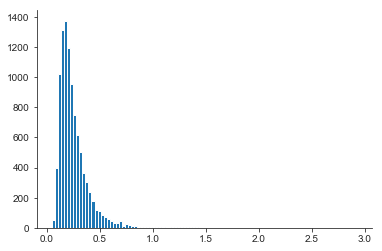

In [88]:
d = tfd.InverseGamma(5, 1).sample(10000)
with tf.Session() as sess:
    sample = sess.run(d)
plt.hist(sample, bins=100);

In [138]:
le = preprocessing.LabelEncoder()
for i in count_table.columns.values:
    count_table[i] = le.fit_transform(count_table[i])

In [139]:
count_table

,genes,conditions,sgrnas,replicates
0,0,0,0,0
1,0,0,0,1
2,0,0,1,0
3,0,0,1,1
4,0,1,2,0
5,0,1,2,1
6,0,1,3,0
7,0,1,3,1
8,1,2,4,0
9,1,2,4,1


## Test

In [238]:
n = 10000
var = tfd.Normal(0, 1).sample(n)
with tf.Session() as sess:
    v = sess.run(var)

[ 0.47087717 -0.19242826  1.2551411  ...  0.34538752 -0.8972587
 -0.63656276]


(array([  27.,  166.,  691., 1768., 2858., 2564., 1418.,  417.,   81.,
          10.]),
 array([-3.5785167 , -2.8390622 , -2.099608  , -1.3601534 , -0.620699  ,
         0.11875546,  0.8582099 ,  1.5976644 ,  2.3371189 ,  3.0765731 ,
         3.8160276 ], dtype=float32),
 <a list of 10 Patch objects>)

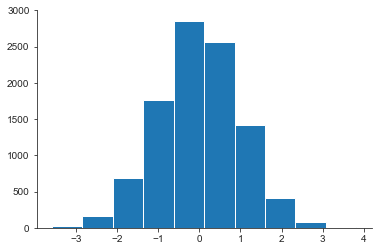

In [239]:
plt.hist(v)

In [310]:
def easy_model(size):
    gamma_tau = ed.InverseGamma(1, 1, name="gamma_tau")
    gamma = ed.Normal(0, gamma_tau, name="gamma")   
    x = ed.Normal(tf.ones(10) * gamma, 1, name="x")
    return x

log_joint = ed.make_log_joint_fn(easy_model)

In [311]:
def target_log_prob_fn(gamma_tau, gamma):
    return log_joint(
        size=len(v),        
        gamma_tau=gamma_tau,
        gamma=gamma,        
        x=v[:10])

In [316]:
num_results = 10000
num_burnin_steps = 10000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros([], name='gamma')
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.4,
        num_leapfrog_steps=3));

In [313]:
num_results = 10000
num_burnin_steps = 10000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros([], name='gamma')
    ],
    kernel=tfp.mcmc.RandomWalkMetropolis(
        target_log_prob_fn=target_log_prob_fn));

In [317]:
gt, g = states
with tf.Session() as sess:
    gt_, g_, is_accepted_, = sess.run([gt, g, kernel_results.is_accepted])

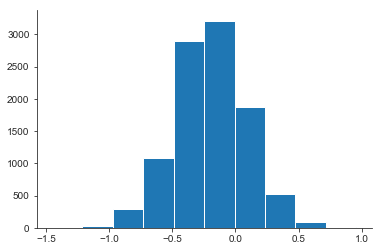

In [318]:
plt.hist(g_);

In [308]:
neff = tfp.mcmc.effective_sample_size(g)
psrf = tfp.mcmc.potential_scale_reduction(g)
with tf.Session() as sess:
    neff_  = sess.run(neff)
neff_

ValueError: Invalid reduction dimension 1 for input with 1 dimensions. for 'potential_scale_reduction_13/potential_scale_reduction_single_state/reduce_variance/Mean' (op: 'Mean') with input shapes: [1], [2] and with computed input tensors: input[1] = <0 1>.

In [224]:
neff_

5.8839893

## Model

In [174]:
def easy_model(count_table, len_g, len_beta, len_l):
    gamma_tau = ed.InverseGamma(10, 1, name="gamma_tau")
    gamma = ed.Normal(tf.zeros(len_g), gamma_tau, name="gamma")
    
    beta_tau = ed.InverseGamma(5, 1, name="beta_tau")
    beta_f = ed.Normal(tf.zeros(len_beta), beta_tau, name="beta_f")
    beta = ed.Deterministic(
        beta_tau * tf.gather(beta_f, count_table['conditions'])
        + tf.gather(gamma, count_table['genes']),
        name="beta")
    
    #l = ed.Normal(tf.zeros(len_l), .25, name="l")
    #le = ed.Deterministic(tf.gather(l, count_table['sgrnas']), name="le")
   
    x = ed.Poisson(tf.exp(beta), name="x")
    return x

log_joint = ed.make_log_joint_fn(easy_model)

In [179]:
def target_log_prob_fn(gamma_tau, gamma, beta_tau, beta_f, beta):
    return log_joint(
        count_table=count_table, 
        len_g=2, len_beta=4, len_l=8,
        gamma_tau=gamma_tau,
        gamma=gamma,
        beta_tau=beta_tau,
        beta_f=beta_f,
        beta=beta,
        #=l,
        #e=le,
        x=x)

In [180]:
x = counts

In [195]:
num_results = 5000
num_burnin_steps = 3000

states, kernel_results = tfp.mcmc.sample_chain(
    num_results=num_results,
    num_burnin_steps=num_burnin_steps,
    current_state=[
        tf.ones([], name='gamma_tau'),
        tf.zeros(2, name='gamma'),
        tf.ones([], name='beta_tau'),
        tf.zeros(4, name='beta_f'),
        tf.zeros(16, name='beta')#,
      #  tf.zeros(8, name='init_l'),
       # tf.zeros(16, name='init_le')
    ],
    kernel=tfp.mcmc.HamiltonianMonteCarlo(
        target_log_prob_fn=target_log_prob_fn,
        step_size=0.1,
        num_leapfrog_steps=10));

In [196]:
states

[<tf.Tensor 'mcmc_sample_chain_10/scan/TensorArrayStack/TensorArrayGatherV3:0' shape=(5000,) dtype=float32>,
 <tf.Tensor 'mcmc_sample_chain_10/scan/TensorArrayStack_1/TensorArrayGatherV3:0' shape=(5000, 2) dtype=float32>,
 <tf.Tensor 'mcmc_sample_chain_10/scan/TensorArrayStack_2/TensorArrayGatherV3:0' shape=(5000,) dtype=float32>,
 <tf.Tensor 'mcmc_sample_chain_10/scan/TensorArrayStack_3/TensorArrayGatherV3:0' shape=(5000, 4) dtype=float32>,
 <tf.Tensor 'mcmc_sample_chain_10/scan/TensorArrayStack_4/TensorArrayGatherV3:0' shape=(5000, 16) dtype=float32>]

In [197]:
_, gamma, _, _, beta  = states

In [198]:
with tf.Session() as sess:
    gamma_, beta_, is_accepted_, = sess.run([gamma, beta, kernel_results.is_accepted])

In [199]:
gamma_

array([[0., 0.],
       [0., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [200]:
beta_

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [206]:
ps = tfp.mcmc.effective_sample_size(gamma_)
with tf.Session() as sess:
    ps_ = sess.run(ps)

In [207]:
ps_

array([nan, nan], dtype=float32)